#  Análise de contestações futuras de débito

In [31]:
import pandas as pd
pd.set_option('display.max_columns', None)

from datetime import datetime
from pyspark.sql import Window
from pyspark.sql.functions import length, col, rowNumber, regexp_extract, concat, format_string, when

In [2]:
def latest(df, ids, timestamp_cols):
    return df \
        .withColumn('_row', rowNumber().over(
            Window \
                .partitionBy(*[col(id) for id in ids]) \
                .orderBy(*[col(timestamp_col).desc() for timestamp_col in timestamp_cols]))) \
        .filter(col('_row') == 1) \
        .drop('_row')

In [3]:
def latest_contcur(df, ids):
    return latest(df, ids, ['contcur'])

In [4]:
def latest_dat_ref_carga(df, ids):
    return latest(df, ids, ['dat_ref_carga'])

In [5]:
base_contestacao_df = sqlContext.table('arq_fraude.base_contestacao')

In [6]:
base_contestacao_latest_df = latest_dat_ref_carga(
    base_contestacao_df \
        .withColumn('numconta', base_contestacao_df.numconta.cast('long').cast('string')),
    ['codent', 'numagencia', 'numconta', 'dttransacao', 'valorfraude'])

In [7]:
compras_contestadas_pred = \
    (base_contestacao_latest_df.canal == 'AUTO ATENDIMENTO') & \
    (base_contestacao_latest_df.descricaotransacao == 'Compras')

In [8]:
contalynx_ok_pred = length(base_contestacao_df.contalynx) == 19

In [9]:
# .filter(contalynx_ok_pred)
compras_contestadas_df = base_contestacao_latest_df \
    .filter(compras_contestadas_pred) \
    .select(
        base_contestacao_latest_df.codent,
        base_contestacao_latest_df.numagencia,
        base_contestacao_latest_df.numconta,
        concat(
            base_contestacao_latest_df.codent,
            base_contestacao_latest_df.numagencia,
            format_string('%012d', base_contestacao_latest_df.numconta.cast('long'))) \
            .alias('ctacargo'),
        base_contestacao_latest_df.cartao,
        base_contestacao_latest_df.dttransacao,
        base_contestacao_latest_df.valorfraude)

In [10]:
mpdt014_df = sqlContext.table('mp.mpdt014')

In [11]:
dat_ref_carga = mpdt014_df.groupBy().agg({'dat_ref_carga': 'max'}).collect()[0][0]
ultima_carga_pred = mpdt014_df.dat_ref_carga == dat_ref_carga

In [12]:
mpdt014_latest_df = latest_contcur(
    mpdt014_df.filter(ultima_carga_pred & (mpdt014_df.indcta == 'P')),
    ['codent', 'centalta', 'cuenta', 'ctacargo'])

In [13]:
contas_contratos_df = mpdt014_latest_df \
    .select(
        mpdt014_latest_df.codent,
        mpdt014_latest_df.centalta,
        mpdt014_latest_df.cuenta,
        mpdt014_latest_df.ctacargo,
        mpdt014_latest_df.fecalta,
        mpdt014_latest_df.fecbaja)

In [14]:
compras_contestadas_contratos_df = compras_contestadas_df \
    .withColumnRenamed('ctacargo', 'ctacargo_gen') \
    .join(
        contas_contratos_df \
            .withColumnRenamed('codent', 'codent_014'),
        (col('ctacargo_gen') == contas_contratos_df.ctacargo) &
        (compras_contestadas_df.dttransacao >= contas_contratos_df.fecalta) &
        (contas_contratos_df.fecbaja.isNull() | (compras_contestadas_df.dttransacao <= contas_contratos_df.fecbaja)),
        'left_outer')

In [15]:
# compras_contestadas_contratos_df.write.mode('overwrite').parquet('hdfs:/user/x181471/compras_contestadas_contratos')

In [16]:
# compras_contestadas_contratos_df = sqlContext.read.parquet('hdfs:/user/x181471/compras_contestadas_contratos')

In [17]:
mpdt090_df = sqlContext.table('mp.mpdt090')

In [18]:
data_attr = 'fecfac'
valor_attr = 'impdiv'
mpdt090_attrs = ['codent', 'centalta', 'cuenta', 'siaidcd', 'fecfac', 'impdiv', 'pan', 'impfac', 'impliq', 'codcom', 'nomcomred', 'codpais', 'nompob', 'fecconta']

In [19]:
mpdt090_latest_df = latest_contcur(
    mpdt090_df.filter(
        mpdt090_df.codcom.isNotNull() & (mpdt090_df.codcom != '')),
    ['codent', 'centalta', 'cuenta', 'siaidcd', data_attr, valor_attr]) \
    .select(*mpdt090_attrs) \
    .withColumnRenamed('codcom', 'codcom_090') \
    .withColumnRenamed('nomcomred', 'nomcomred_090') \
    .withColumnRenamed('impdiv', 'impdiv_090') \
    .withColumnRenamed('pan', 'pan_090') \
    .withColumnRenamed('fecconta', 'fecconta_090') \
    .withColumnRenamed('codpais', 'codpais_090') \

In [20]:
mpdt004_df = sqlContext.table('mp.mpdt004')

In [21]:
mpdt004_latest_df = latest_contcur(mpdt004_df, ['codent', 'centalta', 'cuenta', 'siaidcd'])

In [22]:
mpdt004_df_attrs = ['codent', 'centalta', 'cuenta', 'siaidcd', 'pan', 'imptrn', 'impdiv', 'fectrn', 'hortrn', 'idterm', 'codact', 'codpais', 'codcom', 'nomcom', 'localidad', 'fecconta']

In [23]:
autorizacoes_debito_df = mpdt004_latest_df \
    .filter(
        (mpdt004_latest_df.inddebcre == '2') &
        mpdt004_latest_df.codcom.isNotNull() &
        (mpdt004_latest_df.codcom != '')) \
    .select(*mpdt004_df_attrs) \
    .withColumnRenamed('codcom', 'codcom_004') \
    .withColumnRenamed('nomcom', 'nomcom_004') \
    .withColumnRenamed('impdiv', 'impdiv_004') \
    .withColumnRenamed('pan', 'pan_004') \
    .withColumnRenamed('fecconta', 'fecconta_004') \
    .withColumnRenamed('codpais', 'codpais_004') \

In [24]:
debito_autorizado_df = mpdt090_latest_df.join(
    autorizacoes_debito_df,
    (mpdt090_latest_df.codent == autorizacoes_debito_df.codent) &
    (mpdt090_latest_df.centalta == autorizacoes_debito_df.centalta) &
    (mpdt090_latest_df.cuenta == autorizacoes_debito_df.cuenta) &
    (mpdt090_latest_df.siaidcd == autorizacoes_debito_df.siaidcd),
    'inner') \
    .drop(autorizacoes_debito_df.codent) \
    .drop(autorizacoes_debito_df.centalta) \
    .drop(autorizacoes_debito_df.cuenta) \
    .drop(autorizacoes_debito_df.siaidcd)

In [25]:
# debito_autorizado_df.write.mode('overwrite').parquet('hdfs:/user/x181471/debito_autorizado')
# 40 mins, 48 execs

In [26]:
# debito_autorizado_df = sqlContext.read.parquet('hdfs:/user/x181471/debito_autorizado')
# 31.1 G  93.2 G

In [27]:
debito_df = debito_autorizado_df \
    .join(
        compras_contestadas_contratos_df,
        (compras_contestadas_contratos_df.codent == debito_autorizado_df.codent) &
        (compras_contestadas_contratos_df.centalta == debito_autorizado_df.centalta) &
        (compras_contestadas_contratos_df.cuenta == debito_autorizado_df.cuenta) &
        (compras_contestadas_contratos_df.valorfraude == debito_autorizado_df.impdiv_090) &
        (compras_contestadas_contratos_df.dttransacao == debito_autorizado_df.fecfac),
        'left_outer') \
    .drop(debito_autorizado_df.codent) \
    .drop(debito_autorizado_df.centalta) \
    .drop(debito_autorizado_df.cuenta)

In [28]:
mpdt343_df = sqlContext.table('mp.mpdt343')

In [29]:
mpdt343_latest_df = latest(mpdt343_df, ['cd_idef_sia'], ['dat_ref_carga', 'dh_ulti_atlz'])

In [30]:
# mpdt343_latest_df.write.mode('overwrite').parquet('hdfs:/user/x181471/modo_entrada')
# 15 mins, 180 execs

In [31]:
# mpdt343_latest_df = sqlContext.read.parquet('hdfs:/user/x181471/modo_entrada')

In [32]:
attrs_343 = ['cd_idef_sia', 'in_senh', 'in_codi_segr', 'in_crto_chip', 'nr_crto', 'dh_tran', 'vl_orig_tran', 'cd_empr_grup_sntd', 'nr_cntr_crto', 'cd_idef_tran', 'cd_entr_pos']
input_debito_df = debito_df \
    .withColumn('contestada', debito_df.ctacargo_gen.isNotNull()) \
    .join(
        mpdt343_latest_df \
            .select(*[col(attr) for attr in attrs_343]) \
            .withColumn('in_senh', mpdt343_latest_df.in_senh == '1') \
            .withColumn('in_codi_segr', mpdt343_latest_df.in_codi_segr == '1') \
            .withColumn('in_crto_chip', when(mpdt343_latest_df.in_crto_chip == 'S', True) \
                                       .when(mpdt343_latest_df.in_crto_chip == 'N', False) \
                                       .otherwise(None)),
        debito_df.siaidcd == mpdt343_latest_df.cd_idef_sia,
        'left_outer')

In [33]:
input_debito_df \
    .select(*[col(attr) for attr in ['siaidcd', 'pan_004', 'fectrn', 'hortrn', 'imptrn', 'codcom_004', 'nomcom_004', 'codact', 'idterm', 'cd_entr_pos', 'codpais_004', 'contestada']]) \
    .distinct() \
    .write.mode('overwrite').parquet('hdfs:/user/x181471/input_debito')
# 78 mins, 40 execs
# 49 mins, 50 execs

In [72]:
input_debito_df = sqlContext.read.parquet('hdfs:/user/x181471/input_debito')

In [73]:
input_debito_df.printSchema()

root
 |-- siaidcd: string (nullable = true)
 |-- pan_004: string (nullable = true)
 |-- fectrn: timestamp (nullable = true)
 |-- hortrn: string (nullable = true)
 |-- imptrn: decimal(17,2) (nullable = true)
 |-- codcom_004: string (nullable = true)
 |-- nomcom_004: string (nullable = true)
 |-- codact: decimal(4,0) (nullable = true)
 |-- idterm: string (nullable = true)
 |-- cd_entr_pos: decimal(3,0) (nullable = true)
 |-- codpais_004: decimal(3,0) (nullable = true)
 |-- contestada: boolean (nullable = true)



# Validação

In [35]:
input_debito_df.groupBy(input_debito_df.contestada).count().toPandas()

contestada      count
0       True       1174
1      False  503807853

In [36]:
input_debito_df.select(col('siaidcd')).distinct().count()

503809027

In [37]:
input_debito_df.filter(col('contestada') == True).select(col('siaidcd')).distinct().count()

1174

In [40]:
input_debito_df.filter(col('contestada') == True).limit(40).toPandas()

siaidcd           pan_004     fectrn    hortrn   imptrn  \
0   1025220336969979  4415241614139781 2016-06-30  19:06:51   166.69   
1   1025249364292817  4238088136440287 2016-07-29  12:26:18    48.00   
2   2025126779893950  5021212213676302 2016-03-28  17:51:19    24.04   
3   2025127780205686  5021213325984154 2016-03-29  07:38:08   100.00   
4   2025172842493431  5428206029829815 2016-05-13  16:18:41    20.00   
5   2025191865831017  5021213430661101 2016-06-01  17:08:27  2400.00   
6   2025246939619537  5155900385132249 2016-07-26  08:38:06   237.00   
7   2025246939794272  5447318300055395 2016-07-26  11:34:37    40.88   
8   2025088732635101  5447315728876683 2016-02-19  12:24:26    14.50   
9   2025151815119244  5155901306726564 2016-04-22  14:42:50   100.00   
10  2025192866549554  5021213283154923 2016-06-02  11:25:44   160.90   
11  2025269972983959  5021213216720386 2016-08-18  09:31:35   553.00   
12  1025119241054260  4108637498165903 2016-03-21  12:20:40     0.50   
13  2025090735319247  5155900386987765 2016-02-21  07:32:56   100.00   
14  2025147809644580  5021212533860206 2016-04-18  08:59:39   128.00   
15  2025149813083209  5447315577286208 2016-04-20  20:23:46    27.00   
16  2025206885921788  5211801642520360 2016-06-16  13:33:56   644.53   
17  2025270974437405  5447315724299187 2016-08-19  10:50:05   360.00   
18  1025122244591425  4191903931147645 2016-03-24  19:42:59    10.51   
19  1025238353994764  4191904277621268 2016-07-18  09:53:40   670.00   
20  1025238354637549  4238088189941561 2016-07-18  19:30:22    57.00   
21  2025149812438277  5021213173231849 2016-04-20  14:12:42    16.50   
22  2025196872044139  5021213483466226 2016-06-06  09:03:57     9.56   
23  1025163282604544  4196250025198174 2016-05-04  09:28:52   298.00   
24  2025092738338939  5428205690554512 2016-02-23  23:29:13  1250.00   
25  2025126779191425  5155901340323089 2016-03-28  01:29:29    77.00   
26  2025228914867928  5021213424346032 2016-07-08  09:49:23    85.11   
27  2025256953803232  5428206071707711 2016-08-05  10:42:00    35.00   
28  2025268971812279  5155901295270848 2016-08-17  11:53:32     4.98   
29  0042173016433843  5155900386987765 2016-02-21  08:22:54   500.00   
30  1025085207164464  4745120086622931 2016-02-16  15:50:39    33.00   
31  1025129249874258  4191903931147645 2016-03-31  10:19:03     4.64   
32  1025142262807931  4415243608396005 2016-04-13  09:35:36  2299.90   
33  2025140798128053  5447318360477596 2016-04-11  00:58:12    16.00   
34  2025220904387555  5021213307323256 2016-06-30  23:49:27   210.00   
35  2025259958969512  5021213391453092 2016-08-08  10:16:09   159.00   
36  1025087208654771  4220619326146712 2016-02-18  10:55:36  1790.00   
37  1025205322982138  4220612425813324 2016-06-15  15:10:20   455.00   
38  2025157822399930  5021213099246855 2016-04-28  19:33:26   437.00   
39  2025186859806889  5021212233823900 2016-05-27  15:41:09   410.00   

         codcom_004       nomcom_004 codact    idterm cd_entr_pos codpais_004  \
0   000001041666214  DIAPOR CENTO 94   5411  42224065          51          76   
1         012774014   LOJAO DO VOLKS   5533  DK046814          51          76   
2   000000001482788  BIG BOX SUPERME   5411  30541158          51          76   
3   000000000878283  SERV POSTO PERF   5541  03215412          51          76   
4         011906642  POSTO ZANICHELL   5541  WY139575          51          76   
5   010012780940002  LOJAS AMERICANA   5311  I0085222          51          76   
6         020459726  COMERCIAL RIBEI   5211  WQ483424          51          76   
7         030161525        GUADELUPE   5499  VB116135          51          76   
8         014430754  NOVA PRINCESA D   5462  WQ456795          51          76   
9   000000000453148  AUTO POSTO ARCO   5541  03302965          51          76   
10  010461612180001        ALIKKA VS   5271  02224338          51          76   
11  027500322740001       BARATAO DE   5013  01291541          51          76   
12     

In [41]:
input_debito_df.filter(col('contestada') == True).groupBy(col('pan_004')).count().orderBy(col('count').desc()).limit(40).toPandas()

pan_004  count
0   4220612340388048     25
1   5428204120439931     15
2   5447315782396875     13
3   5021212533860206     12
4   5155900386987765     11
5   5447315724299187     10
6   5155900379639100     10
7   5021213477006392     10
8   5021213283154923      9
9   5447315761540162      8
10  5155900469559952      8
11  5155901339055387      7
12  4415243603355279      7
13  5021212542769828      7
14  5021213437671442      7
15  4191904426237537      7
16  4238088364782087      7
17  4916744143922464      6
18  4238088189941561      6
19  5155901336933255      6
20  4220612177384243      6
21  5447315676732391      6
22  5021212233823900      6
23  4220612341178729      6
24  5021213225173908      6
25  5021213270817060      6
26  5447315577286208      5
27  4220619324885626      5
28  4411206111579874      5
29  5021213458866962      5
30  5021213303193406      5
31  5447318275990691      5
32  5155900219800037      5
33  4191908233913966      5
34  5021212270423416      5
35  5021213213609236      5
36  4196190013235838      5
37  5155900385132249      5
38  5021209741453907      5
39  4415241614139781      5

# Análise

In [32]:
from pyspark.sql.functions import datediff, count, sum, to_date, first

In [33]:
transactions_df = input_debito_df \
    .withColumnRenamed('pan_004', 'cartao') \
    .withColumnRenamed('codcom_004', 'idEstabelecimento') \
    .withColumnRenamed('fectrn', 'dataHoraAutorizacao') \
    .withColumnRenamed('siaidcd', 'idSia') \
    .withColumnRenamed('contestada', 'flagContestacao') \
    .withColumn('valor', col('imptrn').cast('float')).drop(col('imptrn')) \
    .select(col('cartao'), col('idEstabelecimento'), col('dataHoraAutorizacao'), col('idSia'), col('flagContestacao'), col('valor'))

In [34]:
# Passo 1
contestacoes_df = transactions_df \
    .filter(transactions_df.flagContestacao == True) \
    .withColumnRenamed('dataHoraAutorizacao', 'dataHoraAutorizacaoContest') \
    .withColumnRenamed('valor', 'valorContest') \
    .withColumnRenamed('idSia', 'idSiaContest') \
    .drop(transactions_df.flagContestacao) \
    .cache()

In [35]:
# Passo 2
seqs_df = transactions_df \
    .join(contestacoes_df, 'cartao') \
    .filter(datediff(
        contestacoes_df.dataHoraAutorizacaoContest,
        transactions_df.dataHoraAutorizacao) > 0)

In [36]:
# Passo 3
contest_fut_df = seqs_df \
    .groupBy(transactions_df.idSia) \
    .agg(
        count('*').alias('contestFuturas'),
        sum('valorContest').alias('valorTotalContestFuturas')) \
    .alias('contest_fut')

In [37]:
# Passo 4
enriched_transactions_df = transactions_df.withColumnRenamed('idSia', 'idSiaTran') \
    .join(
        contest_fut_df,
        col('idSiaTran') == contest_fut_df.idSia,
        'left_outer') \
    .drop(contest_fut_df.idSia) \
    .na.fill(0, 'contestFuturas') \
    .na.fill(0, 'valorTotalContestFuturas') \
    .withColumnRenamed('idSiaTran', 'idSia')

In [38]:
# Passo 5
enriched_transactions_hist_df = enriched_transactions_df \
    .groupBy(
        transactions_df.idEstabelecimento,
        to_date(transactions_df.dataHoraAutorizacao).alias('date'),
        transactions_df.cartao) \
    .agg(
        count('*').alias('count'),
        first(enriched_transactions_df.contestFuturas) \
            .alias('contestFuturas'),
        first(enriched_transactions_df.valorTotalContestFuturas) \
            .alias('valorTotalContestFuturas'))

In [39]:
# Passo 6
bucket_stats_df = enriched_transactions_hist_df \
    .groupBy(
        enriched_transactions_hist_df.idEstabelecimento,
        enriched_transactions_hist_df.date) \
    .agg(
        count('*').alias('cartoes'),
        sum('count').alias('transacoes'),
        sum(enriched_transactions_hist_df.contestFuturas) \
            .alias('transacoesContestFuturas'),
        sum(when(enriched_transactions_hist_df.contestFuturas > 0, 1) \
                .otherwise(0)) \
            .alias('cartoesContestFuturas'),
        sum(enriched_transactions_hist_df.valorTotalContestFuturas) \
            .alias('valorTotalContestFuturas'))

In [40]:
# Passo 7
transactions_hist_df = contestacoes_df \
    .groupBy(
        contestacoes_df.idEstabelecimento,
        to_date(contestacoes_df.dataHoraAutorizacaoContest).alias('date'),
        contestacoes_df.cartao) \
    .agg(
        count('*').alias('count'),
        sum('valorContest').alias('valorContest'))

In [41]:
# Passo 8
contest_bucket_stats_df = transactions_hist_df \
    .groupBy(
        transactions_hist_df.idEstabelecimento,
        transactions_hist_df.date) \
    .agg(
        count('*').alias('cartoesContest'),
        sum('count').alias('transacoesContest'),
        sum('valorContest').alias('valorTotalContest')) \
    .withColumnRenamed('idEstabelecimento', 'idEstabelecimentoContest') \
    .withColumnRenamed('date', 'dateContest')

In [42]:
# Passo 9
stats_df = bucket_stats_df \
    .join(
        contest_bucket_stats_df,
        (bucket_stats_df.idEstabelecimento == contest_bucket_stats_df.idEstabelecimentoContest) &
        (bucket_stats_df.date == contest_bucket_stats_df.dateContest),
        'left_outer') \
    .drop('idEstabelecimentoContest').drop('dateContest') \
    .na.fill(0, 'cartoesContest') \
    .na.fill(0, 'transacoesContest') \
    .na.fill(0, 'valorTotalContest') \
    .filter(col('transacoesContestFuturas') > 0)

In [43]:
# Passo 10
results_df = stats_df \
    .withColumn('taxaCartoesContestFuturas', stats_df.cartoesContestFuturas / stats_df.cartoes) \
    .withColumn('taxaTransacoesContestFuturas', stats_df.transacoesContestFuturas / stats_df.transacoes) \
    .orderBy(col('taxaCartoesContestFuturas').desc(), stats_df.valorTotalContestFuturas.desc())

In [44]:
results_df.write.mode('overwrite').parquet('hdfs:/user/x181471/input_debito_results')

# Validação

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
results_df = sqlContext.read.parquet('hdfs:/user/x181471/input_debito_results')

In [18]:
results_df.printSchema()

root
 |-- idEstabelecimento: string (nullable = true)
 |-- date: date (nullable = true)
 |-- cartoes: long (nullable = true)
 |-- transacoes: long (nullable = true)
 |-- transacoesContestFuturas: long (nullable = true)
 |-- cartoesContestFuturas: long (nullable = true)
 |-- valorTotalContestFuturas: double (nullable = true)
 |-- cartoesContest: long (nullable = true)
 |-- transacoesContest: long (nullable = true)
 |-- valorTotalContest: double (nullable = true)
 |-- taxaCartoesContestFuturas: double (nullable = true)
 |-- taxaTransacoesContestFuturas: double (nullable = true)



In [46]:
results_df.count()

13481

In [47]:
results_df \
    .filter(col('cartoes') >= 5) \
    .orderBy(col('taxaCartoesContestFuturas').desc()) \
    .limit(40).toPandas()

idEstabelecimento        date  cartoes  transacoes  \
0    010309828880001  2016-05-03        5           6   
1          016977882  2016-03-12        5           5   
2    010582709390001  2016-04-17        5           5   
3    000000001476023  2016-05-14        5           5   
4    010099050980001  2016-04-14        5           5   
5          014591243  2016-03-20        5           5   
6          062888480  2016-05-11        5           5   
7    010327898640001  2016-06-11        5           5   
8    010068002870001  2016-04-06        5           5   
9    000001039357153  2016-06-07        5           5   
10   010408647210001  2016-04-03        5           5   
11   000001035811097  2016-07-01        5           6   
12   010116509300001  2016-02-14        5           5   
13         014591243  2016-03-06        5           5   
14   010494316900001  2016-03-06        5           6   
15         019326262  2016-02-22        5           5   
16   010089513630001  2016-04-11        5           5   
17         014248450  2016-06-25        5           5   
18   000000000315911  2016-04-08        5           5   
19   010425020960001  2016-03-08        5           6   
20   010046172990001  2016-05-25        5           6   
21         010864237  2016-03-05        5           5   
22         016506715  2016-04-03        5           5   
23   010616153210001  2016-06-03        5           6   
24   000000000137879  2016-06-07        5           5   
25   000001054698500  2016-07-01        5           5   
26   010326716340001  2016-07-25        5           9   
27   000000000436241  2016-03-29        5           5   
28   010127764570001  2016-02-20        5           5   
29   000000000877617  2016-02-29        5           8   
30   000000000619251  2016-03-04        5           5   
31   010143351640001  2016-04-06        5           5   
32   010111547030001  2016-04-02        5           5   
33         014713594  2016-03-09        5           5   
34         049642146  2016-03-09        5           5   
35   000000000479844  2016-06-09        5           5   
36         028887930  2016-07-08        5           5   
37         031406734  2016-05-08        5           5   
38   010066459400001  2016-04-10        5           5   
39   010034402980001  2016-05-03        5          10   

    transacoesContestFuturas  cartoesContestFuturas  valorTotalContestFuturas  \
0                          2                      1                 34.000000   
1                          2                      1                 48.800001   
2                          2                      1                 34.000000   
3                          1                      1                 53.099998   
4                          1                      1                 50.000000   
5                          1                      1                 40.000000   
6                          2                      1                 34.000000   
7                          3                      1                 69.510000   
8                          2                      1                 59.000000   
9                          1                      1                 50.000000   
10                         1                      1                 50.000000   
11                         1                      1                 44.000000   
12                         1                      1                 40.080002   
13                         1                      1                 40.000000   
14                         2                      1                 34.000000   
15                         4                      1                 79.000000   
16                         3                      1                 69.510000   
17                         3                      1                 69.510000   
18                         1                      1                 65.839996   
19                         1                 

In [48]:
results_df.orderBy(col('valorTotalContestFuturas').desc()).limit(40).toPandas()

idEstabelecimento        date  cartoes  transacoes  \
0    000000002259203  2016-04-08   178738      189479   
1    000000001259203  2016-03-18   192104      202791   
2    000000001259203  2016-03-05   258140      276962   
3    000000002259203  2016-04-09   156929      165603   
4    000000002259203  2016-04-12   114053      119494   
5    000000002259203  2016-04-06   218734      234088   
6    000000001259203  2016-03-19   180487      190241   
7    000000000107586  2016-04-02    25586       27200   
8    000000003019803  2016-08-06   233856      249304   
9    000000001259203  2016-02-25   124083      130380   
10   000000002259203  2016-06-13    75833       78949   
11   000000002259203  2016-03-20    87582       91039   
12   000101000107586  2016-08-05    34879       36671   
13   000000003019803  2016-08-07   126507      133326   
14   000000002259203  2016-03-24   137838      144379   
15   000000000019901  2016-03-04    51751       54868   
16   000000001259203  2016-03-10   147890      156059   
17   000000004029303  2016-04-10    37902       39217   
18   000000000107586  2016-05-21    24833       26288   
19   000000003019803  2016-06-20   147073      154703   
20   000000002259203  2016-04-14   109782      114849   
21   000000002259203  2016-05-06   253962      271844   
22   000101000107586  2016-06-11    28780       30678   
23   000000002259203  2016-04-20   184940      194953   
24         058111689  2016-07-19       15          15   
25   000000001259203  2016-03-13    87996       91789   
26   000000002259203  2016-03-27    58800       60833   
27   000000001259203  2016-03-17   132810      139567   
28   000000002259203  2016-06-16    89955       93867   
29   000000003019803  2016-08-22   140249      147134   
30   141411593000000  2016-08-08        5           5   
31      948843536376  2016-08-08       75          80   
32         014006677  2016-08-08        5           5   
33      948980472564  2016-08-08        2           2   
34   000101000107586  2016-08-08    18728       19450   
35   000000002259203  2016-05-11   118973      124808   
36   000000002259203  2016-04-16   141936      149064   
37   000000002259203  2016-04-11   130383      136850   
38   000000002259203  2016-04-29   178373      189255   
39   000000003019803  2016-06-01    69419       72782   

    transacoesContestFuturas  cartoesContestFuturas  valorTotalContestFuturas  \
0                         24                     11              13540.190010   
1                         40                      7              11587.870052   
2                         38                      9              11292.020046   
3                         25                     10              10212.860016   
4                         25                     12               9277.329992   
5                         28                     14               9025.600014   
6                         14                      8               8473.900024   
7                         23                      3               8420.909996   
8                         20                      5               8409.030006   
9                         35                      7               8372.390011   
10                        12                      5               8029.190002   
11                        15                      9               7528.500000   
12                        10                      4               7144.950012   
13                        11                      6               7051.200012   
14                        14                      6               6659.000000   
15                         6                      5               6531.680023   
16                        37                      5               6474.390011   
17                         8                      5               6360.910042   
18                         7                      3               6280.000000   
19                         5                 

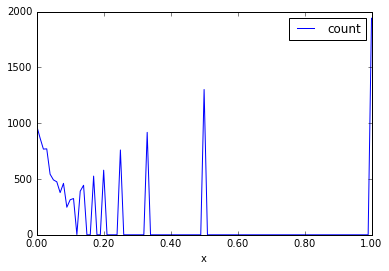

In [95]:
import numpy as np
pd.DataFrame({'x': ['{0:.2f}'.format(x) for x in (np.arange(0, 101) / 100.)]}) \
    .merge(
        results_df \
            .groupBy(
                format_string('%.02f', results_df.taxaCartoesContestFuturas) \
                .alias('taxaCartoesContestFuturas')) \
            .count() \
            .toPandas(),
        'left',
        left_on='x',
        right_on='taxaCartoesContestFuturas') \
    .fillna(0) \
    [['x', 'count']] \
    .set_index('x') \
    .plot.line()